# **Estimating Mobility Flows for Leisure and Care**


---
## MSc Urban Spatial Science

Felipe Almeida

2023





# **Load Packages**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import folium
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
import numpy as np
from math import sqrt
import requests

In [3]:
path = '/content/drive/My Drive/Colab/'

# **Load Data**

In [4]:
OD = pd.read_csv(path + 'OD_level7_nonwork_new.csv')

JOBS = pd.read_csv(path + 'POI_nonwork7_new.csv')

POP = pd.read_csv(path + 'pop7.csv')

# locomizer hexagon grid at level 8
grid8 = gpd.read_file(path + 'grid7.json')

#London borough
LDN_borough = gpd.read_file(path + 'London_borough.json')

In [5]:
DG_nonwork = pd.read_csv( path + 'DG_nonwork.csv')

In [6]:
DG_nonwork

,ORIGIN_CODE,DESTINATION_CODE,flows
0,87195dadeffffff,87194ad09ffffff,7
1,87195dadeffffff,87195dac8ffffff,7
2,87195dadeffffff,87194ad53ffffff,4
3,87195dadeffffff,87194e610ffffff,4
4,87195dadeffffff,87195dad5ffffff,4
...,...,...,...
51870,87195da66ffffff,87194e680ffffff,59
51871,87195da66ffffff,87194e61cffffff,76
51872,87195da66ffffff,87194e61affffff,77
51873,87195da66ffffff,87194aca2ffffff,35


In [7]:
OD

,ORIGIN_CODE,DESTINATION_CODE,FLOWS
0,87194ac00ffffff,87194ac00ffffff,14496.0
1,87194ac00ffffff,87194ac01ffffff,736.0
2,87194ac00ffffff,87194ac02ffffff,483.0
3,87194ac00ffffff,87194ac03ffffff,1403.0
4,87194ac00ffffff,87194ac04ffffff,4255.0
...,...,...,...
172220,87195db6bffffff,87195db5bffffff,0.0
172221,87195db6bffffff,87195db5cffffff,46.0
172222,87195db6bffffff,87195db5dffffff,0.0
172223,87195db6bffffff,87195db69ffffff,161.0


In [8]:
OD = OD.copy()
OD = pd.merge(DG_nonwork, OD, on=['ORIGIN_CODE', 'DESTINATION_CODE'], how= 'inner')
OD.drop(columns=['flows'], inplace=True)

In [9]:
OD

,ORIGIN_CODE,DESTINATION_CODE,FLOWS
0,87195dadeffffff,87194ad09ffffff,0.0
1,87195dadeffffff,87195dac8ffffff,0.0
2,87195dadeffffff,87194ad53ffffff,0.0
3,87195dadeffffff,87194e610ffffff,0.0
4,87195dadeffffff,87195dad5ffffff,46.0
...,...,...,...
51870,87195da66ffffff,87194e680ffffff,0.0
51871,87195da66ffffff,87194e61cffffff,0.0
51872,87195da66ffffff,87194e61affffff,23.0
51873,87195da66ffffff,87194aca2ffffff,0.0


In [10]:
POP

,_index,population
0,87194ac00ffffff,20981.016883
1,87194ac01ffffff,20807.055018
2,87194ac02ffffff,11696.987362
3,87194ac03ffffff,16885.258337
4,87194ac04ffffff,21207.271285
...,...,...
410,87195db5bffffff,20305.808018
411,87195db5cffffff,1447.818893
412,87195db5dffffff,18468.409200
413,87195db69ffffff,1980.493846


In [11]:
JOBS.rename(columns={"all":"jobs"}, inplace = True)
JOBS

,_index,jobs
0,87194ac00ffffff,259
1,87194ac01ffffff,105
2,87194ac02ffffff,65
3,87194ac03ffffff,65
4,87194ac04ffffff,265
...,...,...
410,87195db5bffffff,188
411,87195db5cffffff,8
412,87195db5dffffff,20
413,87195db69ffffff,17


In [12]:
OD

,ORIGIN_CODE,DESTINATION_CODE,FLOWS
0,87195dadeffffff,87194ad09ffffff,0.0
1,87195dadeffffff,87195dac8ffffff,0.0
2,87195dadeffffff,87194ad53ffffff,0.0
3,87195dadeffffff,87194e610ffffff,0.0
4,87195dadeffffff,87195dad5ffffff,46.0
...,...,...,...
51870,87195da66ffffff,87194e680ffffff,0.0
51871,87195da66ffffff,87194e61cffffff,0.0
51872,87195da66ffffff,87194e61affffff,23.0
51873,87195da66ffffff,87194aca2ffffff,0.0


# **Part 1**

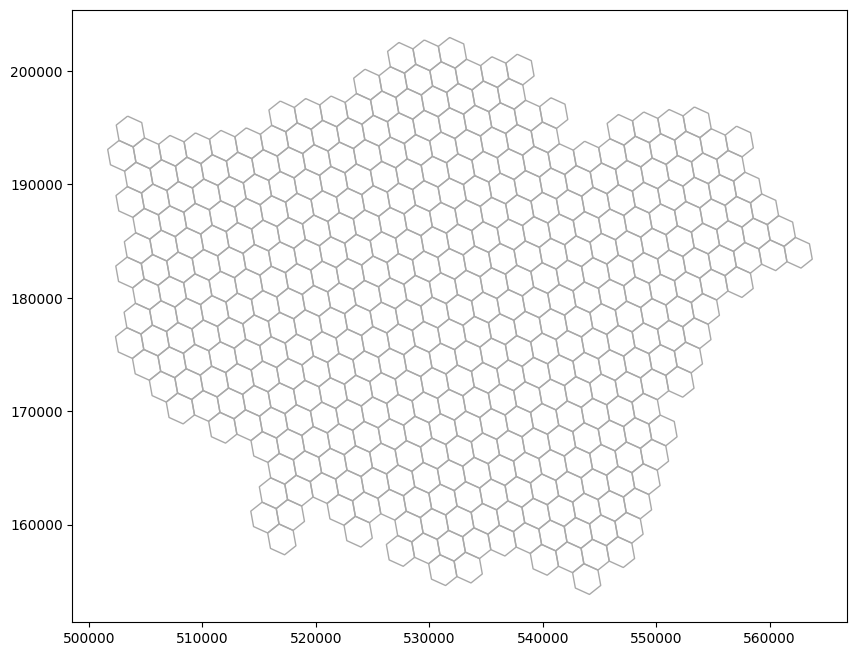

In [13]:
#transform london to BNG
grid8.to_crs("EPSG:27700", inplace = True)
#We can check that this has occured by plotting the results
grid8.plot(figsize = (10,15), facecolor = "None", edgecolor = "darkgray")
plt.show()

In [14]:
#order it by borough code - *This step will be important later on*
grid8.sort_values(by=["_index"], inplace = True)

#extract the centroids
grid8["Centroids"] = grid8.geometry.centroid



In [15]:
# set the index
London = grid8
London.set_index('_index', inplace=True, drop=True)

#calculate distances from all Hex centroids to all Hex centroids
distances = London.rename_axis('Orig').Centroids.apply(lambda x: London.rename_axis('Dest').Centroids.distance(x)).stack().reset_index()
distances.rename(columns = {0:'Dist'}, inplace=True)
distances.sort_values(by=["Orig", "Dest"], inplace = True)
London.reset_index(inplace=True)

London

,_index,geometry,Centroids
0,87194ac00ffffff,"POLYGON ((530198.675 161408.835, 529201.343 16...",POINT (530444.193 160052.310)
1,87194ac01ffffff,"POLYGON ((531687.078 159487.402, 530689.887 15...",POINT (531932.646 158130.811)
2,87194ac02ffffff,"POLYGON ((527958.284 161182.457, 526960.606 16...",POINT (528203.746 159825.736)
3,87194ac03ffffff,"POLYGON ((529446.920 159260.759, 528449.383 15...",POINT (529692.431 157903.971)
4,87194ac04ffffff,"POLYGON ((530950.217 163556.354, 529953.090 16...",POINT (531195.743 162200.092)
...,...,...,...
410,87195db5bffffff,"POLYGON ((525811.072 198212.705, 524814.675 19...",POINT (526056.262 196859.377)
411,87195db5cffffff,"POLYGON ((527312.727 202492.207, 526316.744 20...",POINT (527557.932 201139.413)
412,87195db5dffffff,"POLYGON ((528799.155 200573.363, 527803.312 19...",POINT (529044.412 199220.499)
413,87195db69ffffff,"POLYGON ((537741.407 201455.283, 536746.951 20...",POINT (537986.901 200103.204)


In [16]:
JOBS

,_index,jobs
0,87194ac00ffffff,259
1,87194ac01ffffff,105
2,87194ac02ffffff,65
3,87194ac03ffffff,65
4,87194ac04ffffff,265
...,...,...
410,87195db5bffffff,188
411,87195db5cffffff,8
412,87195db5dffffff,20
413,87195db69ffffff,17


In [17]:
POP

,_index,population
0,87194ac00ffffff,20981.016883
1,87194ac01ffffff,20807.055018
2,87194ac02ffffff,11696.987362
3,87194ac03ffffff,16885.258337
4,87194ac04ffffff,21207.271285
...,...,...
410,87195db5bffffff,20305.808018
411,87195db5cffffff,1447.818893
412,87195db5dffffff,18468.409200
413,87195db69ffffff,1980.493846


In [18]:
# Merge the two DataFrames based on the common column '_index' and keep all keys
merged_df = pd.merge(JOBS, POP, on='_index', how='outer')

# Replace NaN values with zeros
merged_df = merged_df.fillna(0)

#merge on the origins
OD = OD.merge(merged_df, left_on='ORIGIN_CODE', right_on='_index', how='outer')
OD.drop(columns = ["_index"], inplace = True)
OD.rename(columns={"population":"origpop", "jobs": "origjob"}, inplace = True)

#merge on the destinations
OD = OD.merge(merged_df, left_on='DESTINATION_CODE', right_on='_index', how='outer')
OD.drop(columns = ["_index"], inplace = True)
OD.rename(columns={"population":"destpop", "jobs": "destjobs"}, inplace = True)

# Replace NaN values with zeros
OD = OD.fillna(0)

# Remove rows with value '0' in 'ORIGIN_CODE'
OD = OD[OD['ORIGIN_CODE'] != '0']
OD = OD[OD['DESTINATION_CODE'] != '0']

# Convert 'ORIGIN_CODE' column to string
OD['ORIGIN_CODE'] = OD['ORIGIN_CODE'].astype(str)

# Remove rows with value '0' in 'ORIGIN_CODE'
OD = OD[OD['ORIGIN_CODE'] != '0']

In [19]:
OD

,ORIGIN_CODE,DESTINATION_CODE,FLOWS,origjob,origpop,destjobs,destpop
0,87195dadeffffff,87194ad09ffffff,0.0,225,2677.032081,143.0,10177.561857
1,87195da69ffffff,87194ad09ffffff,0.0,923,65512.504770,143.0,10177.561857
2,87195d363ffffff,87194ad09ffffff,0.0,117,12675.875827,143.0,10177.561857
3,87195db48ffffff,87194ad09ffffff,0.0,518,18541.435199,143.0,10177.561857
4,87194e69affffff,87194ad09ffffff,0.0,859,62914.130670,143.0,10177.561857
...,...,...,...,...,...,...,...
51870,87194ad25ffffff,87195daebffffff,0.0,229,29427.308631,264.0,30674.534057
51871,87195da54ffffff,87195daebffffff,0.0,482,20901.159334,264.0,30674.534057
51872,87195da4affffff,87195daebffffff,92.0,1016,44336.670863,264.0,30674.534057
51873,87194adaeffffff,87195daebffffff,0.0,511,44336.754693,264.0,30674.534057


In [20]:
#the data needs to be ordered by borough code, if it's not then we will run into problems when we try to merge the
#distance data back in later
OD.sort_values(by=["ORIGIN_CODE", "DESTINATION_CODE"], inplace = True)

#reset the resulting index (important for later) when merging back together
OD.reset_index(inplace=True)
OD.drop(columns = ["index"], inplace=True)

#first we create a new total column which excludes intra-borough flow totals (we will set them
#to a very small number for reasons you will see later)
OD["TotalNoIntra"] = OD.apply(lambda x: 0 if x['ORIGIN_CODE'] == x['DESTINATION_CODE'] else x['FLOWS'], axis=1)

#set the number to a very small number
OD["offset"]= OD.apply(lambda x: 0.0000000001 if x['ORIGIN_CODE'] == x['DESTINATION_CODE'] else 0, axis=1)

In [21]:
distances

,Orig,Dest,Dist
0,87194ac00ffffff,87194ac00ffffff,0.000000
1,87194ac00ffffff,87194ac01ffffff,2430.565498
2,87194ac00ffffff,87194ac02ffffff,2251.874795
3,87194ac00ffffff,87194ac03ffffff,2276.072309
4,87194ac00ffffff,87194ac04ffffff,2275.476462
...,...,...,...
172220,87195db6bffffff,87195db5bffffff,10156.365660
172221,87195db6bffffff,87195db5cffffff,8290.118175
172222,87195db6bffffff,87195db5dffffff,6740.416649
172223,87195db6bffffff,87195db69ffffff,2245.531445


In [22]:
## ADD DISTANCE INTO THE DATAFRAME

# create a commom index in distance dataframe
distances['combined'] = distances['Orig'] + ',' + distances['Dest']
distances.drop(columns = ['Orig', 'Dest'], inplace=True)

#create a commom index in OD
OD['combined'] = OD['ORIGIN_CODE'] + ',' + OD['DESTINATION_CODE']

#add distance into the dataframe
OD = OD.merge(distances, left_on='combined', right_on='combined', how='inner')

# remove column
OD.drop(columns = ["combined"], inplace = True)

# Convert origpop and destpop columns to integers
OD['origpop'] = OD['origpop'].astype(int)
OD['destpop'] = OD['destpop'].astype(int)
OD['FLOWS'] = OD['FLOWS'].astype(int)
OD['TotalNoIntra'] = OD['TotalNoIntra'].astype(int)
OD

,ORIGIN_CODE,DESTINATION_CODE,FLOWS,origjob,origpop,destjobs,destpop,TotalNoIntra,offset,Dist
0,87194ac00ffffff,87194ac00ffffff,14496,259,20981,259.0,20981,0,1.000000e-10,0.000000
1,87194ac00ffffff,87194ac01ffffff,736,259,20981,105.0,20807,736,0.000000e+00,2430.565498
2,87194ac00ffffff,87194ac02ffffff,483,259,20981,65.0,11696,483,0.000000e+00,2251.874795
3,87194ac00ffffff,87194ac03ffffff,1403,259,20981,65.0,16885,1403,0.000000e+00,2276.072309
4,87194ac00ffffff,87194ac04ffffff,4255,259,20981,265.0,21207,4255,0.000000e+00,2275.476462
...,...,...,...,...,...,...,...,...,...,...
51870,87195db69ffffff,87195db5bffffff,0,17,1980,188.0,20305,0,0.000000e+00,12363.759359
51871,87195db69ffffff,87195db5cffffff,0,17,1980,8.0,1447,0,0.000000e+00,10480.320186
51872,87195db69ffffff,87195db5dffffff,0,17,1980,20.0,18468,0,0.000000e+00,8985.948094
51873,87195db69ffffff,87195db69ffffff,1888,17,1980,17.0,1980,0,1.000000e-10,0.000000


In [23]:
#now chop out the intra-borough flows
OD = OD[OD["ORIGIN_CODE"] != OD["DESTINATION_CODE"]]

In [24]:
OD

,ORIGIN_CODE,DESTINATION_CODE,FLOWS,origjob,origpop,destjobs,destpop,TotalNoIntra,offset,Dist
1,87194ac00ffffff,87194ac01ffffff,736,259,20981,105.0,20807,736,0.0,2430.565498
2,87194ac00ffffff,87194ac02ffffff,483,259,20981,65.0,11696,483,0.0,2251.874795
3,87194ac00ffffff,87194ac03ffffff,1403,259,20981,65.0,16885,1403,0.0,2276.072309
4,87194ac00ffffff,87194ac04ffffff,4255,259,20981,265.0,21207,4255,0.0,2275.476462
5,87194ac00ffffff,87194ac05ffffff,1035,259,20981,114.0,20963,1035,0.0,2251.236531
...,...,...,...,...,...,...,...,...,...,...
51869,87195db69ffffff,87195db5affffff,0,17,1980,14.0,2942,0,0.0,13482.744331
51870,87195db69ffffff,87195db5bffffff,0,17,1980,188.0,20305,0,0.0,12363.759359
51871,87195db69ffffff,87195db5cffffff,0,17,1980,8.0,1447,0,0.0,10480.320186
51872,87195db69ffffff,87195db5dffffff,0,17,1980,20.0,18468,0,0.0,8985.948094


In [25]:
OD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51750 entries, 1 to 51874
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORIGIN_CODE       51750 non-null  object 
 1   DESTINATION_CODE  51750 non-null  object 
 2   FLOWS             51750 non-null  int64  
 3   origjob           51750 non-null  int64  
 4   origpop           51750 non-null  int64  
 5   destjobs          51750 non-null  float64
 6   destpop           51750 non-null  int64  
 7   TotalNoIntra      51750 non-null  int64  
 8   offset            51750 non-null  float64
 9   Dist              51750 non-null  float64
dtypes: float64(3), int64(5), object(2)
memory usage: 4.3+ MB


In [26]:
#### Create Origin Destination matrix
OD_pivot = pd.pivot_table(OD,
                    values ="FLOWS",
                    index="ORIGIN_CODE",
                    columns = "DESTINATION_CODE",
                    aggfunc=sum,
                    margins=True)
OD_pivot.fillna(0, inplace=True)
OD_pivot = OD_pivot.astype(int)
OD_pivot.sort_values(by='All').tail(10)
OD_pivot

DESTINATION_CODE,87194ac00ffffff,87194ac01ffffff,87194ac02ffffff,87194ac03ffffff,87194ac04ffffff,87194ac05ffffff,87194ac06ffffff,87194ac0cffffff,87194ac0effffff,87194ac10ffffff,...,87195db4effffff,87195db58ffffff,87195db59ffffff,87195db5affffff,87195db5bffffff,87195db5cffffff,87195db5dffffff,87195db69ffffff,87195db6bffffff,All
ORIGIN_CODE,,,,,,,,,,,,,,,,,,,,,
87194ac00ffffff,0,736,483,1403,4255,1035,1702,161,23,138,...,0,0,0,0,0,0,0,0,0,16399
87194ac01ffffff,3151,0,46,1127,1794,621,460,3611,437,0,...,0,0,0,0,0,0,0,0,0,15318
87194ac02ffffff,2967,115,0,851,874,115,897,0,0,368,...,0,0,0,0,0,0,0,0,0,10350
87194ac0cffffff,805,3956,276,138,1564,1288,0,0,759,161,...,0,0,0,0,0,0,0,0,0,19665
87194ac0effffff,1081,989,0,322,368,92,69,1311,0,92,...,0,0,0,0,0,0,0,0,0,5267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87195db4affffff,0,0,0,0,0,0,0,0,0,0,...,92,115,92,0,0,0,414,0,207,10258
87195db4cffffff,0,0,0,0,0,0,0,0,0,0,...,46,0,0,0,0,0,0,46,207,1150
87195db5affffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,46,0,0,0,0,1150


In [27]:
OD

,ORIGIN_CODE,DESTINATION_CODE,FLOWS,origjob,origpop,destjobs,destpop,TotalNoIntra,offset,Dist
1,87194ac00ffffff,87194ac01ffffff,736,259,20981,105.0,20807,736,0.0,2430.565498
2,87194ac00ffffff,87194ac02ffffff,483,259,20981,65.0,11696,483,0.0,2251.874795
3,87194ac00ffffff,87194ac03ffffff,1403,259,20981,65.0,16885,1403,0.0,2276.072309
4,87194ac00ffffff,87194ac04ffffff,4255,259,20981,265.0,21207,4255,0.0,2275.476462
5,87194ac00ffffff,87194ac05ffffff,1035,259,20981,114.0,20963,1035,0.0,2251.236531
...,...,...,...,...,...,...,...,...,...,...
51869,87195db69ffffff,87195db5affffff,0,17,1980,14.0,2942,0,0.0,13482.744331
51870,87195db69ffffff,87195db5bffffff,0,17,1980,188.0,20305,0,0.0,12363.759359
51871,87195db69ffffff,87195db5cffffff,0,17,1980,8.0,1447,0,0.0,10480.320186
51872,87195db69ffffff,87195db5dffffff,0,17,1980,20.0,18468,0,0.0,8985.948094


# **Part 2**

In [28]:
#take the variables and produce logarithms of them
x_variables = ["destpop", "destjobs", "Dist"]
log_x_vars = []
for x in x_variables:
    OD[f"log_{x}"] = np.log(OD[x]+1)
    log_x_vars.append(f"log_{x}")

<ipython-input-28-857f0a8b48bf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OD[f"log_{x}"] = np.log(OD[x]+1)
<ipython-input-28-857f0a8b48bf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OD[f"log_{x}"] = np.log(OD[x]+1)
<ipython-input-28-857f0a8b48bf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [56]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'FLOWS ~ ORIGIN_CODE + log_destjobs + log_Dist-1'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=OD, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  FLOWS   No. Observations:                51750
Model:                            GLM   Df Residuals:                    51623
Model Family:                 Poisson   Df Model:                          126
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0679e+06
Date:                Thu, 07 Sep 2023   Deviance:                   2.0920e+06
Time:                        13:18:44   Pearson chi2:                 8.91e+06
No. Iterations:                    31   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
ORIGIN_CODE[8719

In [57]:
unique_strings2 = OD['ORIGIN_CODE'].unique()

In [58]:
unique_strings2

array(['87194ac00ffffff', '87194ac01ffffff', '87194ac02ffffff',
       '87194ac0cffffff', '87194ac0effffff', '87194ac10ffffff',
       '87194ac12ffffff', '87194ac16ffffff', '87194ac1cffffff',
       '87194ac20ffffff', '87194ac22ffffff', '87194ac24ffffff',
       '87194ac28ffffff', '87194ac2effffff', '87194ac31ffffff',
       '87194aca2ffffff', '87194aca4ffffff', '87194aca5ffffff',
       '87194aca6ffffff', '87194ad00ffffff', '87194ad05ffffff',
       '87194ad06ffffff', '87194ad0dffffff', '87194ad13ffffff',
       '87194ad18ffffff', '87194ad21ffffff', '87194ad22ffffff',
       '87194ad23ffffff', '87194ad25ffffff', '87194ad29ffffff',
       '87194ad2bffffff', '87194ad2cffffff', '87194ad2effffff',
       '87194ad32ffffff', '87194ad34ffffff', '87194ad35ffffff',
       '87194ad41ffffff', '87194ad43ffffff', '87194ad46ffffff',
       '87194ad58ffffff', '87194ad5affffff', '87194ad5dffffff',
       '87194ad60ffffff', '87194ad64ffffff', '87194ad70ffffff',
       '87194ad74ffffff', '87194ad82ffff

In [59]:
count_total2 = len(unique_strings2)
print(count_total2)

125


In [60]:
prodSim.params[126]

-2.991920498071937

In [61]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(OD.groupby(["ORIGIN_CODE"])["FLOWS"].agg(np.sum))
O_i.rename(columns={"FLOWS":"O_i"}, inplace = True)
OD = OD.merge(O_i, on = "ORIGIN_CODE", how = "left" )

D_j = pd.DataFrame(OD.groupby(["DESTINATION_CODE"])["FLOWS"].agg(np.sum))
D_j.rename(columns={"FLOWS":"D_j"}, inplace = True)
OD = OD.merge(D_j, on = "DESTINATION_CODE", how = "left" )

In [62]:
#We can do this by pulling out the parameter values
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(ORIGIN_CODE)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
#then once you have done this you can join them back into the dataframes
OD = OD.merge(coefs, left_on="ORIGIN_CODE", right_on="coef", how = "left")
OD.drop(columns = ["coef"], inplace = True)
#check this has worked
OD.head()

<ipython-input-62-19ff58c5147f>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,ORIGIN_CODE,DESTINATION_CODE,FLOWS,origjob,origpop,destjobs,destpop,TotalNoIntra,offset,Dist,...,O_i_x,D_j_x,alpha_i_x,prodsimest1,O_i_y,D_j_y,alpha_i_y,O_i,D_j,alpha_i
0,87194ac00ffffff,87194ac01ffffff,736,259,20981,105.0,20807,736,0.0,2430.565498,...,16399,6601,28.365447,3.239070e+155,16399,6601,28.365447,16399,6601,28.365447
1,87194ac00ffffff,87194ac02ffffff,483,259,20981,65.0,11696,483,0.0,2251.874795,...,16399,1288,28.365447,9.243135e+148,16399,1288,28.365447,16399,1288,28.365447
2,87194ac00ffffff,87194ac03ffffff,1403,259,20981,65.0,16885,1403,0.0,2276.072309,...,16399,4738,28.365447,1.216959e+149,16399,4738,28.365447,16399,4738,28.365447
3,87194ac00ffffff,87194ac04ffffff,4255,259,20981,265.0,21207,4255,0.0,2275.476462,...,16399,14329,28.365447,6.688103e+165,16399,14329,28.365447,16399,14329,28.365447
4,87194ac00ffffff,87194ac05ffffff,1035,259,20981,114.0,20963,1035,0.0,2251.236531,...,16399,4577,28.365447,4.292341e+155,16399,4577,28.365447,16399,4577,28.365447


In [63]:
alpha_i = prodSim.params[0:124]
gamma = prodSim.params[125]
beta = -prodSim.params[126]

In [64]:
alpha_i

ORIGIN_CODE[87194ac00ffffff]    28.365447
ORIGIN_CODE[87194ac01ffffff]    28.611032
ORIGIN_CODE[87194ac02ffffff]    28.124548
ORIGIN_CODE[87194ac0cffffff]    29.477434
ORIGIN_CODE[87194ac0effffff]    28.134854
                                  ...    
ORIGIN_CODE[87195db43ffffff]    26.197918
ORIGIN_CODE[87195db48ffffff]    28.504532
ORIGIN_CODE[87195db4affffff]    27.658864
ORIGIN_CODE[87195db4cffffff]    25.746231
ORIGIN_CODE[87195db5affffff]    26.107155
Length: 124, dtype: float64

In [65]:
gamma

0.48232026451616883

In [66]:
OD["prodsimest1"] = np.exp(OD["alpha_i"]+gamma*OD["log_destjobs"]
                                 - beta*OD["log_Dist"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
OD.head(10)

,ORIGIN_CODE,DESTINATION_CODE,FLOWS,origjob,origpop,destjobs,destpop,TotalNoIntra,offset,Dist,...,O_i_x,D_j_x,alpha_i_x,prodsimest1,O_i_y,D_j_y,alpha_i_y,O_i,D_j,alpha_i
0,87194ac00ffffff,87194ac01ffffff,736,259,20981,105.0,20807,736,0.0,2430.565498,...,16399,6601,28.365447,1463.867076,16399,6601,28.365447,16399,6601,28.365447
1,87194ac00ffffff,87194ac02ffffff,483,259,20981,65.0,11696,483,0.0,2251.874795,...,16399,1288,28.365447,1463.650605,16399,1288,28.365447,16399,1288,28.365447
2,87194ac00ffffff,87194ac03ffffff,1403,259,20981,65.0,16885,1403,0.0,2276.072309,...,16399,4738,28.365447,1417.606207,16399,4738,28.365447,16399,4738,28.365447
3,87194ac00ffffff,87194ac04ffffff,4255,259,20981,265.0,21207,4255,0.0,2275.476462,...,16399,14329,28.365447,2778.832063,16399,14329,28.365447,16399,14329,28.365447
4,87194ac00ffffff,87194ac05ffffff,1035,259,20981,114.0,20963,1035,0.0,2251.236531,...,16399,4577,28.365447,1914.780566,16399,4577,28.365447,16399,4577,28.365447
5,87194ac00ffffff,87194ac06ffffff,1702,259,20981,84.0,21929,1702,0.0,2430.618131,...,16399,6877,28.365447,1315.907321,16399,6877,28.365447,16399,6877,28.365447
6,87194ac00ffffff,87194ac0cffffff,161,259,20981,5.0,182,161,0.0,4861.077788,...,16399,5428,28.365447,46.089004,16399,5428,28.365447,16399,5428,28.365447
7,87194ac00ffffff,87194ac0effffff,23,259,20981,15.0,6514,23,0.0,4136.236651,...,16399,1495,28.365447,119.899901,16399,1495,28.365447,16399,1495,28.365447
8,87194ac00ffffff,87194ac10ffffff,138,259,20981,68.0,12176,138,0.0,6148.519020,...,16399,3910,28.365447,74.124181,16399,3910,28.365447,16399,3910,28.365447
9,87194ac00ffffff,87194ac12ffffff,23,259,20981,0.0,0,23,0.0,8305.889789,...,16399,1449,28.365447,3.911191,16399,1449,28.365447,16399,1449,28.365447


In [67]:
#first round the estimates
OD["prodsimest1"] = round(OD["prodsimest1"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
OD2_pivot = OD.pivot_table(values ="prodsimest1", index="ORIGIN_CODE", columns = "DESTINATION_CODE",
                            aggfunc=np.sum, margins=True)
OD2_pivot

DESTINATION_CODE,87194ac00ffffff,87194ac01ffffff,87194ac02ffffff,87194ac03ffffff,87194ac04ffffff,87194ac05ffffff,87194ac06ffffff,87194ac0cffffff,87194ac0effffff,87194ac10ffffff,...,87195db4effffff,87195db58ffffff,87195db59ffffff,87195db5affffff,87195db5bffffff,87195db5cffffff,87195db5dffffff,87195db69ffffff,87195db6bffffff,All
ORIGIN_CODE,,,,,,,,,,,,,,,,,,,,,
87194ac00ffffff,NaN,1464.0,1464.0,1418.0,2779.0,1915.0,1316.0,46.0,120.0,74.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,16392.0
87194ac01ffffff,2885.0,NaN,313.0,1872.0,595.0,2370.0,212.0,468.0,915.0,40.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,15307.0
87194ac02ffffff,2228.0,242.0,NaN,915.0,464.0,189.0,1259.0,16.0,58.0,196.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10344.0
87194ac0cffffff,863.0,4451.0,200.0,744.0,385.0,944.0,150.0,NaN,2248.0,47.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,19659.0
87194ac0effffff,365.0,1414.0,116.0,925.0,109.0,185.0,58.0,366.0,NaN,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5263.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87195db4affffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,692.0,95.0,829.0,18.0,152.0,28.0,332.0,9.0,67.0,10245.0
87195db4cffffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,105.0,3.0,7.0,1.0,4.0,2.0,8.0,7.0,172.0,1117.0
87195db5affffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,121.0,29.0,NaN,203.0,12.0,11.0,0.0,2.0,1122.0


In [68]:
OD_pivot

DESTINATION_CODE,87194ac00ffffff,87194ac01ffffff,87194ac02ffffff,87194ac03ffffff,87194ac04ffffff,87194ac05ffffff,87194ac06ffffff,87194ac0cffffff,87194ac0effffff,87194ac10ffffff,...,87195db4effffff,87195db58ffffff,87195db59ffffff,87195db5affffff,87195db5bffffff,87195db5cffffff,87195db5dffffff,87195db69ffffff,87195db6bffffff,All
ORIGIN_CODE,,,,,,,,,,,,,,,,,,,,,
87194ac00ffffff,0,736,483,1403,4255,1035,1702,161,23,138,...,0,0,0,0,0,0,0,0,0,16399
87194ac01ffffff,3151,0,46,1127,1794,621,460,3611,437,0,...,0,0,0,0,0,0,0,0,0,15318
87194ac02ffffff,2967,115,0,851,874,115,897,0,0,368,...,0,0,0,0,0,0,0,0,0,10350
87194ac0cffffff,805,3956,276,138,1564,1288,0,0,759,161,...,0,0,0,0,0,0,0,0,0,19665
87194ac0effffff,1081,989,0,322,368,92,69,1311,0,92,...,0,0,0,0,0,0,0,0,0,5267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87195db4affffff,0,0,0,0,0,0,0,0,0,0,...,92,115,92,0,0,0,414,0,207,10258
87195db4cffffff,0,0,0,0,0,0,0,0,0,0,...,46,0,0,0,0,0,0,46,207,1150
87195db5affffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,46,0,0,0,0,1150


In [69]:
OD

,ORIGIN_CODE,DESTINATION_CODE,FLOWS,origjob,origpop,destjobs,destpop,TotalNoIntra,offset,Dist,...,O_i_x,D_j_x,alpha_i_x,prodsimest1,O_i_y,D_j_y,alpha_i_y,O_i,D_j,alpha_i
0,87194ac00ffffff,87194ac01ffffff,736,259,20981,105.0,20807,736,0.0,2430.565498,...,16399,6601,28.365447,1464.0,16399,6601,28.365447,16399,6601,28.365447
1,87194ac00ffffff,87194ac02ffffff,483,259,20981,65.0,11696,483,0.0,2251.874795,...,16399,1288,28.365447,1464.0,16399,1288,28.365447,16399,1288,28.365447
2,87194ac00ffffff,87194ac03ffffff,1403,259,20981,65.0,16885,1403,0.0,2276.072309,...,16399,4738,28.365447,1418.0,16399,4738,28.365447,16399,4738,28.365447
3,87194ac00ffffff,87194ac04ffffff,4255,259,20981,265.0,21207,4255,0.0,2275.476462,...,16399,14329,28.365447,2779.0,16399,14329,28.365447,16399,14329,28.365447
4,87194ac00ffffff,87194ac05ffffff,1035,259,20981,114.0,20963,1035,0.0,2251.236531,...,16399,4577,28.365447,1915.0,16399,4577,28.365447,16399,4577,28.365447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51745,87195db69ffffff,87195db5affffff,0,17,1980,14.0,2942,0,0.0,13482.744331,...,6739,230,28.106666,3.0,6739,230,28.106666,6739,230,28.106666
51746,87195db69ffffff,87195db5bffffff,0,17,1980,188.0,20305,0,0.0,12363.759359,...,6739,1909,28.106666,12.0,6739,1909,28.106666,6739,1909,28.106666
51747,87195db69ffffff,87195db5cffffff,0,17,1980,8.0,1447,0,0.0,10480.320186,...,6739,345,28.106666,4.0,6739,345,28.106666,6739,345,28.106666
51748,87195db69ffffff,87195db5dffffff,0,17,1980,20.0,18468,0,0.0,8985.948094,...,6739,851,28.106666,10.0,6739,851,28.106666,6739,851,28.106666


In [70]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""

    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2

    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""

    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)

    return RMSE

In [71]:
CalcRSquared(OD["FLOWS"], OD["prodsimest1"])

0.7992860533261408

In [72]:
CalcRMSE(OD["FLOWS"], OD["prodsimest1"])

141.193

In [73]:
SIM_work  = OD[['ORIGIN_CODE', 'DESTINATION_CODE', 'prodsimest1']]
SIM_work.rename( columns= {'prodsimest1': 'flows'}, inplace=True )
SIM_work.to_csv(path + 'SIM_nonwork.csv', index=False)

SIM_work

<ipython-input-73-13af5d324620>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SIM_work.rename( columns= {'prodsimest1': 'flows'}, inplace=True )


,ORIGIN_CODE,DESTINATION_CODE,flows
0,87194ac00ffffff,87194ac01ffffff,1464.0
1,87194ac00ffffff,87194ac02ffffff,1464.0
2,87194ac00ffffff,87194ac03ffffff,1418.0
3,87194ac00ffffff,87194ac04ffffff,2779.0
4,87194ac00ffffff,87194ac05ffffff,1915.0
...,...,...,...
51745,87195db69ffffff,87195db5affffff,3.0
51746,87195db69ffffff,87195db5bffffff,12.0
51747,87195db69ffffff,87195db5cffffff,4.0
51748,87195db69ffffff,87195db5dffffff,10.0


<Axes: xlabel='TotalNoIntra'>

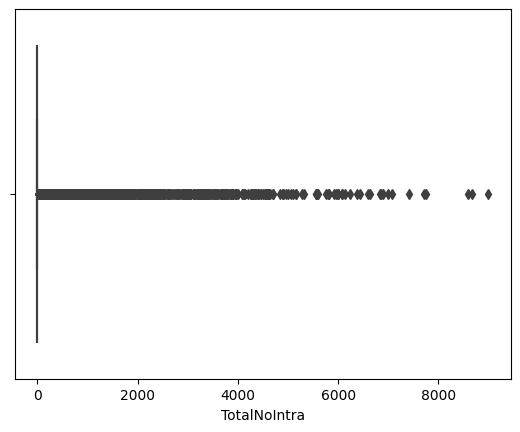

In [47]:
sns.boxplot(x=OD["TotalNoIntra"])

In [48]:
# Group 'data22' by 'station_destination' and calculate the sum of 'flows' and 'prod_exp4'
grouped_data = OD.groupby("DESTINATION_CODE").agg({'TotalNoIntra': 'sum', 'prodsimest1': 'sum'})

# Sort the grouped data based on the 'prod_exp4' values
sorted_data = grouped_data.sort_values(by="prodsimest1", ascending=False)

# Add a new column 'Difference' to show the difference between 'flows' and 'prod_exp4'
sorted_data['Difference'] = sorted_data['prodsimest1'] - sorted_data['TotalNoIntra']

# Select the top 10 destinations
top_10_destinations = sorted_data.head(10)

# Display the top 10 destinations with the number of jobs and difference
rounded_destinations = round(top_10_destinations, 0)
rounded_destinations['Difference'] = rounded_destinations['Difference'].fillna(0)  # Replace NaN with 0
print(rounded_destinations)
rounded_destinations

                  TotalNoIntra    prodsimest1     Difference
DESTINATION_CODE                                            
87195da49ffffff          20818  1.443639e+228  1.443639e+228
87194ad32ffffff           9154  3.056355e+223  3.056355e+223
87194ad30ffffff          17112  5.411917e+222  5.411917e+222
87194ad36ffffff          14283  3.754485e+218  3.754485e+218
87195da4dffffff          17319  1.618803e+218  1.618803e+218
87194ada4ffffff          15112  5.835954e+217  5.835954e+217
87194ad16ffffff           6854  5.433791e+217  5.433791e+217
87195da48ffffff          23828  7.240004e+214  7.240004e+214
87194ad34ffffff           9890  5.865794e+214  5.865794e+214
87194ad33ffffff          12190  1.023683e+214  1.023683e+214


,TotalNoIntra,prodsimest1,Difference
DESTINATION_CODE,,,
87195da49ffffff,20818,1.443639e+228,1.443639e+228
87194ad32ffffff,9154,3.056355e+223,3.056355e+223
87194ad30ffffff,17112,5.411917e+222,5.411917e+222
87194ad36ffffff,14283,3.754485e+218,3.754485e+218
87195da4dffffff,17319,1.618803e+218,1.618803e+218
87194ada4ffffff,15112,5.835954e+217,5.835954e+217
87194ad16ffffff,6854,5.433791e+217,5.433791e+217
87195da48ffffff,23828,7.240004e+214,7.240004e+214
87194ad34ffffff,9890,5.865794e+214,5.865794e+214
